## Some misc. code snippets while learning diffusion

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload
# import libraries
import numpy as np
import pickle as pkl
import os
import sys
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch
%matplotlib inline

from celeba_dataset import CelebA
from unet_diffusion import UNet_Diffusion, get_time_embedding
from noise_scheduler import LinearNoiseScheduler

------------------------------------------
### Experiments that give good results:

<hr>

### Experiment 1:  Jan 11, 2024

-  No augmentations other than horizontal flips (do NOT use Gaussian blur from pytorch packages since this messes up the scheduled noising of the images)
-  The AttentionBlock uses nn.MultiheadAttention with number heads = 4
-  Attention=True only for self.down_1, self.down_2, self.up_2, self.up_1 (all others false)
-  img_shape = (64,64), batch_size=64, two-gpu strategy='ddp_find_unused_parameters_true'
-  time_emb dimension = 256
-  Epochs = 154 (~220K batches of 64 images)
-  num_timesteps = 1000, beta_start = 0.0001, beta_end = 0.02
-  Exponential moving average with warmup of 2000 batches
-  Adam optimizer, lr = 0.0002, b1 = 0.5, b2 = 0.999
-  scheduler = None

| <img src="images/x0_0_nn.MHSA_154_epochs.png" alt="" width="300"/>  | <img src="images/training_loss_154_epochs_nn_MHSA.png" alt="" width="300"/>  |
|:--:| 



-  {'img_size': [64, 64], 'time_emb_dim': 256, 'channels': [64, 128, 256, 512, 1024], 'down_attn': [False, True, True, False], 'down_channel_indices': [[0, 0], [0, 1], [1, 2], [2, 3]], 'mid_attn': [False, False, False], 'mid_channel_indices': [[3, 4], [4, 4], [4, 3]], 'up_attn': [True, True, False], 'up_channel_indices': [[3, 2], [2, 1], [1, 0]], 'num_heads': 4}
-  {'log_dir': './lightning_logs/', 'batch_size': 64, 'num_epochs': 200, 'restart': False, 'checkpoint_name': 'none', 'log_every_nsteps': 1000, 'accelerator': 'gpu', 'devices': 2, 'save_top_k': 
10, 'checkpoint_every_n_epochs': 1, 'monitor': 'loss', 'mode': 'min'}




<hr>

### Experiment 2: Jan 12, 2024

-  The AttentionBlock uses my multiheaded self attention code instead of pytorch's code.
-  Number of heads = 4
-  No augmentations other than horizontal flips
-  Attention=True only for self.down_1, self.down_2, self.up_2, self.up_1 (all others false)
-  img_shape = (64,64), batch_size=84, two-gpu strategy='ddp_find_unused_parameters_true'
-  time_emb dimension = 256
-  Epochs 105, (~150K batches of 64 images)
-  num_timesteps = 1000, beta_start = 0.0001, beta_end = 0.02
-  Exponential moving average with warmup of 2000 batches
-  Adam optimizer, lr = 0.0001, b1 = 0.5, b2 = 0.999
-  scheduler = none

| <img src="images/x0_0_my_MHSA_105_epochs.png" alt="" width="300"/> | <img src="images/training_loss_105_epochs_my_MHSA.png" alt="" width="300"/> | 
|:--:|

-  {'img_size': [64, 64], 'time_emb_dim': 256, 'channels': [64, 128, 256, 512, 1024], 'down_attn': [False, True, True, False], 'down_channel_indices': [[0, 0], [0, 1], [1, 2], [2, 3]], 'mid_attn': [False, False, False], 'mid_channel_indices': [[3, 4], [4, 4], [4, 3]], 'up_attn': [True, True, False], 'up_channel_indices': [[3, 2], [2, 1], [1, 0]], 'num_heads': 4}
-  {'log_dir': './lightning_logs/', 'batch_size': 64, 'num_epochs': 300, 'restart': False, 'checkpoint_name': 'none', 'log_every_nsteps': 1000, 'accelerator': 'gpu', 'devices': 2, 'save_top_k': 10, 'checkpoint_every_n_epochs': 1, 'monitor': 'loss', 'mode': 'min'}
-  {'train_path': '../data/img_align_celeba/img_align_celeba/train/', 'valid_path': '../data/img_align_celeba/img_align_celeba/valid/', 'limit_size': False, 'size_limit': -1}



<hr>

### Experiment 3: Jan 13, 2024

Same as Experiment 2, but with dropout = 0.1  Background color seems "better"

 <img src="images/x0_0_my_MHSA_dropout_0p1_147_epochs.png" alt="" width="300"/> 




<hr>

### Experiment 4: Jan 20, 2024  

Same as Experiment 3, but now allow for attention head dimension to be specified for each layer in the network.

-  img_size: [64,64]
-  num_heads: 12
-  {'dataset_params': {'train_path': '../data/img_align_celeba/img_align_celeba/train/', 'valid_path': '../data/img_align_celeba/img_align_celeba/valid/', 'limit_size': False, 'size_limit': -1}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02}, 'model_params': {'img_size': [64, 64], 'time_emb_dim': 256, 'channels': [64, 128, 256, 512, 1024], 'down_attn': [False, True, True, False], 'down_channel_indices': [[0, 0], [0, 1], [1, 2], [2, 3]], 'down_head_sizes': [32, 64, 128, 256], 'mid_attn': [False, False, False], 'mid_channel_indices': [[3, 4], [4, 4], [4, 3]], 'mid_head_sizes': [64, 64, 64], 'up_attn': [True, True, False], 'up_channel_indices': [[3, 2], [2, 1], [1, 0]], 'up_head_sizes': [128, 64, 32], 'num_heads': 12, 'dropout': 0.1, 'attn_dropout': 0.1}, 'train_params': {'log_dir': './lightning_logs/', 'batch_size': 24, 'num_epochs': 200, 'restart': False, 'checkpoint_name': 'None', 'log_every_nsteps': 1000, 'accelerator': 'gpu', 'devices': 2, 'save_top_k': 5, 'checkpoint_every_n_epochs': 1, 'monitor': 'loss', 'mode': 'min'}}

### Result: meh...  no better than the simpler approach with single attn head size for all blocks.



<hr>

### Experiment 5: Jan 20, 2024  

-  img_size: [96,96]
-  num_heads: 4
-  dim_head: 64
-  batch_size: 18
-  {'dataset_params': {'train_path': '../data/img_align_celeba/img_align_celeba/train/', 'valid_path': '../data/img_align_celeba/img_align_celeba/valid/', 'limit_size': False, 'size_limit': -1}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02}, 'model_params': {'img_size': [96, 96], 'time_emb_dim': 256, 'channels': [64, 128, 256, 512, 1024], 'down_attn': [False, True, True, False], 'down_channel_indices': [[0, 0], [0, 1], [1, 2], [2, 3]], 'mid_attn': [False, False, False], 'mid_channel_indices': [[3, 4], [4, 4], [4, 3]], 'up_attn': [True, True, False], 'up_channel_indices': [[3, 2], [2, 1], [1, 0]], 'num_heads': 4, 'dim_head': 64, 'dropout': 0.1, 'attn_dropout': 0.1}, 'train_params': {'log_dir': './lightning_logs/', 'batch_size': 18, 'num_epochs': 200, 'restart': False, 'checkpoint_name': 'None', 'log_every_nsteps': 1000, 'accelerator': 'gpu', 'devices': 2, 'save_top_k': 10, 'checkpoint_every_n_epochs': 1, 'monitor': 'loss', 'mode': 'min'}}

### Meh!  no discernable face-like images generated


<hr>

### try using nn.MultiheadSelfAttention code instead of mine 

-  image size = [96,96]
-  num heads: 4, result: similar to my failed experiments below.  Gen images contain no face-like data.
-  num heads: 8, same result as num_heads=4.  No face-like data generated.

-  image_size: [32,32], num heads: 8



#### Maybe for larger images, attention is needed at more layers in the UNet?



<hr>

#### Jan 23, 2024:  Try with varying levels of attention

- img_size: [64,64]
- num_heads : 4
- dim_head : 64

#### No attention
 <img src="images/x0_0_no_attention.png" alt="" title="No Attention" width="400"/>
 
 #### Attention in Downblock layer 2 only (32x32 feature map size)
 -  batch_size: 90
 -  epochs: 401
 
 <img src="images/x0_0_attn_down_layer2.png" alt="" width="400"/> 

 #### Attention in Downblock layer 3 only (16x16 feature map size)
 -  batch_size: 256 
 -  epochs: 650

 <img src="images/x0_0_attn_down_layer3.png" alt="" width="400"/> 



<hr>

### Jan 26-28, 2024.  Try larger image size (128,128)
 - img_size: [128,128]
- num_heads : 4
- dim_head : 64

 #### Attention in Downblock layer 3 only (32x32 feature map size)
 -  batch_size: 80 
 -  epochs: 400 (checkpoint was from epoch 385 since lowest loss weights are saved)

 <img src="images/x0_0_128x128_attn_down_layer3.png" alt="" width="400"/> 



<hr>

### Jan 28-, 2024.  Try larger image size (128,128)
 - img_size: [128,128]
- num_heads : 8 (double #heads from above)
- dim_head : 64

 #### Attention in Downblock layer 3 only (32x32 feature map size)
 -  batch_size: 50
 -  epochs: 315 total epochs.
 -  results do improve between 222 to 315 epochs.

 <img src="images/x0_0_128x128_attn_down_layer3_8heads_222epochs.png" alt="" width="400"/>  <img src="images/x0_0_128x128_attn_down_layer3_8heads_315epochs.png" alt="" width="400"/> 


<hr>

### Jan 30-, 2024.  More work on (128,128)  In progress
- img_size: [128,128]
- num_heads : 8 
- dim_head : 64
- attention in both down and up blocks at the 16x16 resolution only
- batch size: 96


 <img src="images/blah.png" alt="" width="400"/>


<hr>

### TODO

- revisit mixed and/or single precision.



---------------------------------------------------------
## Inference

In [ ]:
img_size = (128,128) 
batch_size = 8 
num_timesteps = 1000
beta_start = 0.0001
beta_end = 0.02
lns = LinearNoiseScheduler(num_timesteps, beta_start, beta_end)


In [ ]:
# Instantiate the model
time_emb_dim = 256 #128


import torchvision
import argparse
import yaml
import os
from torchvision.utils import make_grid
from unet_diffusion import UNet_Diffusion
from diffusion_lightning import DDPM
from tqdm import tqdm

num_samples = 36
num_grid_rows = 6
im_channels = 3
im_size = img_size[0]
num_timesteps = 1000
beta_start = 0.0001
beta_end = 0.02
task_name = 'default'

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')


def sample(model, scheduler):
    """
    Sample stepwise by going backward one timestep at a time.
    We save the x0 predictions
    """

    # # Create two random vectors and interpolate between them.
    # rand_a = torch.randn(im_channels, im_size, im_size)
    # rand_b = torch.randn(im_channels, im_size, im_size)
    # delta_ab = rand_a - rand_b
    # samples = []
    # samples.append(rand_a)
    # delt = 1.0/num_samples
    # for i in range(1, (num_samples-1), 1):
    #     s = rand_a + (i * delt) * delta_ab
    #     samples.append(s)

    # samples.append(rand_b)
    # xt = torch.stack(samples).to(device)
    # print('xt shape:', xt.shape)

    xt = torch.randn((num_samples, im_channels, im_size, im_size)).to(device)

    for i in tqdm(reversed(range(num_timesteps))):
        # Get prediction of noise
        noise_pred = model(xt, torch.as_tensor(i).unsqueeze(0).to(device))
        
        # Use scheduler to get x0 and xt-1
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))
        
        # Save x0 every 200th time.
        if i % 200 == 0 or (i == num_timesteps-1):
            ims = torch.clamp(xt, -1., 1.).detach().cpu()
            ims = (ims + 1) / 2
            grid = make_grid(ims, nrow=num_grid_rows)
            img = torchvision.transforms.ToPILImage()(grid)
            if not os.path.exists(os.path.join(task_name, 'samples')):
                os.mkdir(os.path.join(task_name, 'samples'))
            img.save(os.path.join(task_name, 'samples', 'x0_{}.png'.format(i)))
            img.close()


def infer():
    model = DDPM.load_from_checkpoint(checkpoint_path='/home/mark/dev/diffusion/lightning_logs/version_9/checkpoints/epoch=93-step=171456.ckpt')
    model.ema_model = None # dump the extra EMA model used at train-time only
    total_params = sum(param.numel() for param in model.parameters())
    print('Model has:', int(total_params//1e6), 'M parameters')
    model.eval()
    model.to(device)
    
    # Create the noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=num_timesteps,
                                     beta_start=beta_start,
                                     beta_end=beta_end)
    with torch.no_grad():
        sample(model.model, scheduler)

    return



#----------------------------------------------------
# Run the inference
#----------------------------------------------------
infer()


<hr>

### Perception-prioritized Weighting during training.
https://arxiv.org/pdf/2204.00227.pdf

#### Reproduced Fig 3 (left and right-most plots) from above paper.

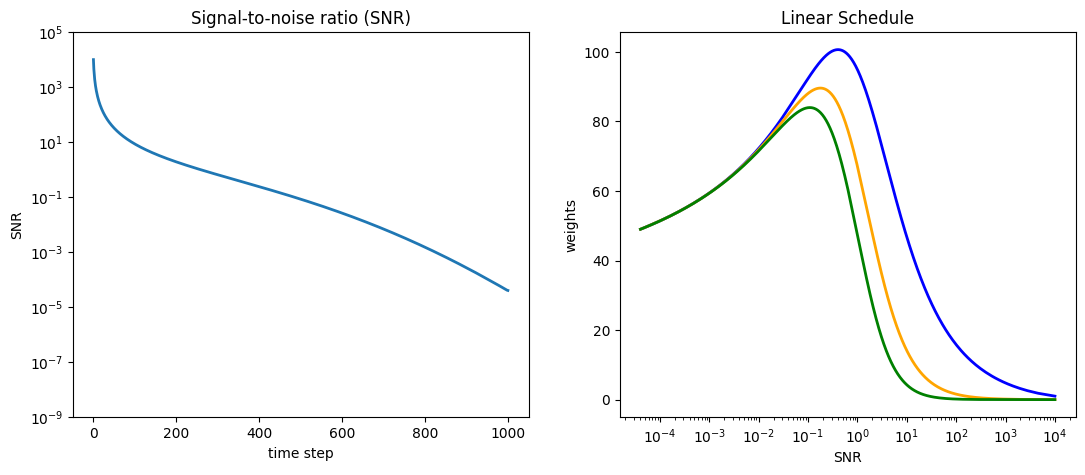

In [ ]:
# Perception-prioritized weighting during training 
# https://arxiv.org/pdf/2204.00227.pdf

import matplotlib.pyplot as plt

alpha_cum_prod = lns.alpha_cum_prod 
betas = lns.betas
alphas = lns.alphas

lambda_t = ((1 - betas) * (1 - alpha_cum_prod))/betas
snr =  (1.0/(1.0 - alpha_cum_prod)) - 1  #alpha_cum_prod/(1.0 - alpha_cum_prod) 
t_steps = torch.linspace(0, 1000, 1000, dtype=torch.int)
assert snr.shape == t_steps.shape

p2_k = 1
p2_gamma = 0.5  
weights_0p5 = (lambda_t/(p2_k + snr)**p2_gamma)
# plot normalized weights.
# weights_0p5 /= (torch.sum(torch.abs(weights_0p5)))
# print(torch.sum(weights_0p5))

p2_gamma = 1.0  
weights_1p0 = (lambda_t/(p2_k + snr)**p2_gamma)
# weights_1p0 /= (torch.sum(torch.abs(weights_1p0)))
# print(torch.sum(weights_1p0))

weights_baseline = lambda_t
# weights_baseline /= (torch.sum(torch.abs(weights_baseline)))
# print(torch.sum(weights_baseline))

rows = 1
cols = 3
fig = plt.figure(figsize=(20,5))

ax = plt.subplot(rows, cols, 1)
ax.plot(t_steps, snr, linewidth=2.0)
plt.title('Signal-to-noise ratio (SNR)')
plt.xlabel('time step')
plt.ylabel('SNR')
plt.yscale("log")
plt.ylim(1e-9, 1e5)

ax = plt.subplot(rows, cols, 2)
ax.plot(snr, weights_baseline, linewidth=2.0, color="blue")
ax.plot(snr, weights_0p5, linewidth=2.0, color="orange")
ax.plot(snr, weights_1p0, linewidth=2.0, color="green")
plt.title('Linear Schedule')
plt.xlabel('SNR')
plt.ylabel('weights')
plt.xscale("log")
# plt.xlim(1e-8, 50)

# ax = plt.subplot(rows, cols, 3)
# ax.plot(t_steps, torch.log10(snr)/weights_baseline, linewidth=2.0, color="blue")
# ax.plot(t_steps, torch.log10(snr)/weights_0p5, linewidth=2.0, color="orange")
# ax.plot(t_steps, torch.log10(snr)/weights_1p0, linewidth=2.0, color="green")
# plt.title('')
# plt.ylabel('SNR / weights')
# plt.xlabel('time steps')
# plt.xscale("log")
# plt.xlim(1e-8, 1e4)

plt.show()

In [ ]:
flowers = torchvision.datasets.Flowers102(root='../data/', split='train', download=True)

In [ ]:
# Debug the PP weights stuff added to noise_scheduler class.

# Perception-prioritized weighting during training 
# https://arxiv.org/pdf/2204.00227.pdf

import matplotlib.pyplot as plt

t_steps = torch.linspace(0, 999, 1000, dtype=torch.int)
weights = lns.get_pp_weights(t_steps)
for i in range(3):
    weights = weights.squeeze()

snr = lns.snr[t_steps]
print('weights shape:', weights.shape)
print('snr shape:', snr.shape)

# weights_1p0 /= (torch.sum(torch.abs(weights_1p0)))
# print(torch.sum(weights_1p0))

rows = 1
cols = 1
fig = plt.figure(figsize=(5,5))

ax = plt.subplot(rows, cols, 1)
ax.plot(snr, weights, linewidth=2.0, color="green")
plt.title('Linear Schedule')
plt.xlabel('SNR')
plt.ylabel('weights')
plt.xscale("log")
# plt.xlim(1e-8, 50)

plt.show()

----------------
## Misc debugging code for the AttentionBlock (pytorch's vs. the hand-crafted version)

In [ ]:
import numpy as np
import pickle as pkl
import os
import sys
import torchvision.utils as vutils


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch
from einops import rearrange
from einops.layers.torch import Rearrange
from torch import nn
from math import prod

class AttentionBlock(nn.Module):
    def __init__(self, dim, num_heads=4, dim_head=64, numgroups=8, dropout=0.):  
        super().__init__()        
        inner_dim = dim_head * num_heads
        # dim_head = dim // num_heads
        # inner_dim = dim 
        print('dim:', dim, ', inner dim:', inner_dim)

        project_out = not (num_heads == 1 and dim_head == dim)
        self.heads = num_heads
        self.attention_norm = nn.GroupNorm(numgroups, dim)
        self.scale = float(dim_head) ** -0.5
        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.attn_dropout = nn.Dropout(dropout)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, c, h, w = x.shape
        print('[b, c, h, w]:', b, c, h, w)
        in_attn = x.reshape(b, c, h * w)
        print('1. in_attn shape:', in_attn.shape)
        # GroupNorm applies only to the c channels, so the dimensions of the tensor 
        # after that is probably not important either way
        in_attn = self.attention_norm(in_attn) 

        # in_attn = rearrange(in_attn, 'b c (h p1 w p2) -> b (p1 p2 c) (h w)', h=4, p1 = 16, w=4, p2 = 16) # shit, nah! doesn't work
        in_attn = in_attn.transpose(1,2)
        
        print('2. in_attn shape:', in_attn.shape)
        qkv = self.to_qkv(in_attn).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)
        print('q shape:', q.shape, ', k shape:', k.shape, ', v shape:', v.shape)
        print('q Mb:', (prod(q.shape)*8)/1e6)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        print('dots shape:', dots.shape, ', size Mb:', (prod(dots.shape)*8)/1e6)
        attn = self.attend(dots)
        attn = self.attn_dropout(attn)
        out = torch.matmul(attn, v)
        print('out shape:', out.shape, ', size Mb:', (prod(out.shape)*8)/1e6)
        # # print('1. out shape:', out.shape)
        # out = rearrange(out, 'b h n d -> b n (h d)')
        # # print('2. out shape:', out.shape)
        # out = self.to_out(out)
        # # print('3. out shape:', out.shape)
        # out = out.transpose(1, 2).reshape(b, c, h, w)
        # # print('4. out shape:', out.shape)
        return None #out     





import collections
# class AttentionBlock(nn.Module):
#     def __init__(self, out_channels, num_heads=4, numgroups=8):
#         super().__init__()
#         self.attention_norms = nn.GroupNorm(numgroups, out_channels)
#         self.attentions = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)

#         # self.head_dim = embed_dim // num_heads from torch source code
#         # assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"
        
#         # Get each instance variable
#         for key_value in self.attentions.__dict__.items():
#             data = key_value[1]
#             if isinstance(data, collections.OrderedDict):
#                 for k, v in data.items():
#                     if torch.is_tensor(v):
#                         print('k:', k, ', shape:', v.shape)
#             else:
#                 print(key_value[0], '=', key_value[1])

#     def forward(self, x):
#         out = x
#         # Attention block of Unet
#         batch_size, channels, h, w = out.shape
#         in_attn = out.reshape(batch_size, channels, h * w)
#         in_attn = self.attention_norms(in_attn)
#         in_attn = in_attn.transpose(1, 2)    #So, I guess: [N, (h*w), C] where (h*w) is the target "sequence length", and C is the embedding dimension
#         out_attn, _ = self.attentions(in_attn, in_attn, in_attn)
#         print('\nout_attn shape:', out_attn.shape)
#         out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
#         return out_attn


In [ ]:
# channels = [32, 64, 128, 256, 512]
channels = [64, 128, 256, 512, 1024]
down_channel_indices = [[0,0], [0,1], [1,2], [2,3]] # in, out indices into channels[] for each down layer
heads = 4
dim_head = 64
b = 1
shape = 64
for (in_idx, out_idx) in (down_channel_indices):
    attn1 = AttentionBlock(channels[in_idx], num_heads=heads, dim_head=dim_head)
    c = channels[in_idx]
    h = w = shape
    x = torch.randn((b, c, h, w))
    out = attn1.forward(x)
    shape = shape//2
    break
    print('\n\n')



# attn1 = AttentionBlock(emb_dim, heads)
# out = attn1.forward(x)


In [ ]:
from einops.layers.torch import Rearrange
from einops import repeat, rearrange
patch_dim = 16
in_channels = 64
img_shape = 64

token_dim = patch_dim * patch_dim * in_channels  # length of linearized rgb patchs
# dim = dim # The embedding dimension for the Encoder
# num_patches = ((img_shape[0]//patch_dim) * (img_shape[0]//patch_dim))

# chunk1 = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_dim, p2 = patch_dim)
chunk1 = Rearrange('b c (h p1) (w p2) -> b (p1 p2 c) (h w)', p1 = patch_dim, p2 = patch_dim)
# chunk1 = Rearrange('b c (h p1) (w p2) -> b (h w) c (p1 p2)', p1 = patch_dim, p2 = patch_dim)
chunk2 = nn.Conv2d(in_channels, in_channels, (8,8), 8)

x = torch.randn([1, in_channels, img_shape, img_shape])
print('x shape:', x.shape)

x1 = chunk1(x)
print('chunk1 x1 shape:', x1.shape)

x1 = chunk2(x)
print('chunk2 x1 shape:', x1.shape)


In [ ]:
dim = 256
heads = 4
dim_head =128
inner_dim = dim_head *  heads
numgroups = 8

x = torch.randn([2, 256, 32, 32])
print('in x shape:', x.shape)

b, c, h, w = x.shape
norm = nn.GroupNorm(numgroups, dim)
in_attn = norm(x)
in_attn = x.reshape(b, h * w, c)
# in_attn = in_attn.transpose(1, 2)  # reshape to [b, (h*w), c] i.e. [b, seq, emb_dim]
print('in_attn shape:', in_attn.shape)


to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
print('to_qkv, mean:', torch.mean(to_qkv.weight.data), ', std:', torch.std(to_qkv.weight.data))
nn.init.normal_(to_qkv.weight.data, mean=0., std=np.sqrt(2 / (dim+inner_dim)))
print('to_qkv, mean:', torch.mean(to_qkv.weight.data), ', std:', torch.std(to_qkv.weight.data))
nn.init.xavier_normal_(to_qkv.weight.data)
print('to_qkv, mean:', torch.mean(to_qkv.weight.data), ', std:', torch.std(to_qkv.weight.data))


qkv = to_qkv(in_attn)
print('out shape:', qkv.shape)

qkv = qkv.chunk(3, dim = -1)
print('q shape:', qkv[0].shape)

q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = heads), qkv)
print('q shape:', q.shape)


dots = torch.matmul(q, k.transpose(-1, -2)) 
print('dots shape:', dots.shape)

out = torch.matmul(dots, v)
print('1 out shape:', out.shape)

out = rearrange(out, 'b h n d -> b n (h d)')
print('2 out shape:', out.shape)

to_out = nn.Linear(inner_dim, dim)

out = to_out(out)
print('3 out shape:', out.shape)

out = out.transpose(1, 2).reshape(b, c, h, w)
print('4 out shape:', out.shape)


In [ ]:
class MultiheadAttention(Module):
    r"""Allows the model to jointly attend to information
    from different representation subspaces as described in the paper:
    `Attention Is All You Need <https://arxiv.org/abs/1706.03762>`_.

    Multi-Head Attention is defined as:

    .. math::
        \text{MultiHead}(Q, K, V) = \text{Concat}(head_1,\dots,head_h)W^O

    where :math:`head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)`.

    ``nn.MultiHeadAttention`` will use the optimized implementations of
    ``scaled_dot_product_attention()`` when possible.

    In addition to support for the new ``scaled_dot_product_attention()``
    function, for speeding up Inference, MHA will use
    fastpath inference with support for Nested Tensors, iff:

    - self attention is being computed (i.e., ``query``, ``key``, and ``value`` are the same tensor).
    - inputs are batched (3D) with ``batch_first==True``
    - Either autograd is disabled (using ``torch.inference_mode`` or ``torch.no_grad``) or no tensor argument ``requires_grad``
    - training is disabled (using ``.eval()``)
    - ``add_bias_kv`` is ``False``
    - ``add_zero_attn`` is ``False``
    - ``batch_first`` is ``True`` and the input is batched
    - ``kdim`` and ``vdim`` are equal to ``embed_dim``
    - if a `NestedTensor <https://pytorch.org/docs/stable/nested.html>`_ is passed, neither ``key_padding_mask``
      nor ``attn_mask`` is passed
    - autocast is disabled

    If the optimized inference fastpath implementation is in use, a
    `NestedTensor <https://pytorch.org/docs/stable/nested.html>`_ can be passed for
    ``query``/``key``/``value`` to represent padding more efficiently than using a
    padding mask. In this case, a `NestedTensor <https://pytorch.org/docs/stable/nested.html>`_
    will be returned, and an additional speedup proportional to the fraction of the input
    that is padding can be expected.

    Args:
        embed_dim: Total dimension of the model.
        num_heads: Number of parallel attention heads. Note that ``embed_dim`` will be split
            across ``num_heads`` (i.e. each head will have dimension ``embed_dim // num_heads``).
        dropout: Dropout probability on ``attn_output_weights``. Default: ``0.0`` (no dropout).
        bias: If specified, adds bias to input / output projection layers. Default: ``True``.
        add_bias_kv: If specified, adds bias to the key and value sequences at dim=0. Default: ``False``.
        add_zero_attn: If specified, adds a new batch of zeros to the key and value sequences at dim=1.
            Default: ``False``.
        kdim: Total number of features for keys. Default: ``None`` (uses ``kdim=embed_dim``).
        vdim: Total number of features for values. Default: ``None`` (uses ``vdim=embed_dim``).
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False`` (seq, batch, feature).

    Examples::

        >>> # xdoctest: +SKIP
        >>> multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
        >>> attn_output, attn_output_weights = multihead_attn(query, key, value)

    .. _`FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness`:
         https://arxiv.org/abs/2205.14135

    """

    __constants__ = ['batch_first']
    bias_k: Optional[torch.Tensor]
    bias_v: Optional[torch.Tensor]

    def __init__(self, embed_dim, num_heads, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False,
                 kdim=None, vdim=None, batch_first=False, device=None, dtype=None) -> None:
        if embed_dim <= 0 or num_heads <= 0:
            raise ValueError(
                f"embed_dim and num_heads must be greater than 0,"
                f" got embed_dim={embed_dim} and num_heads={num_heads} instead"
            )
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.batch_first = batch_first
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        if not self._qkv_same_embed_dim:
            self.q_proj_weight = Parameter(torch.empty((embed_dim, embed_dim), **factory_kwargs))
            self.k_proj_weight = Parameter(torch.empty((embed_dim, self.kdim), **factory_kwargs))
            self.v_proj_weight = Parameter(torch.empty((embed_dim, self.vdim), **factory_kwargs))
            self.register_parameter('in_proj_weight', None)
        else:
            self.in_proj_weight = Parameter(torch.empty((3 * embed_dim, embed_dim), **factory_kwargs))
            self.register_parameter('q_proj_weight', None)
            self.register_parameter('k_proj_weight', None)
            self.register_parameter('v_proj_weight', None)

        if bias:
            self.in_proj_bias = Parameter(torch.empty(3 * embed_dim, **factory_kwargs))
        else:
            self.register_parameter('in_proj_bias', None)
        self.out_proj = NonDynamicallyQuantizableLinear(embed_dim, embed_dim, bias=bias, **factory_kwargs)

        if add_bias_kv:
            self.bias_k = Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
            self.bias_v = Parameter(torch.empty((1, 1, embed_dim), **factory_kwargs))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn

        self._reset_parameters()

    def _reset_parameters(self):
        if self._qkv_same_embed_dim:
            xavier_uniform_(self.in_proj_weight)
        else:
            xavier_uniform_(self.q_proj_weight)
            xavier_uniform_(self.k_proj_weight)
            xavier_uniform_(self.v_proj_weight)

        if self.in_proj_bias is not None:
            constant_(self.in_proj_bias, 0.)
            constant_(self.out_proj.bias, 0.)
        if self.bias_k is not None:
            xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            xavier_normal_(self.bias_v)

    def __setstate__(self, state):
        # Support loading old MultiheadAttention checkpoints generated by v1.1.0
        if '_qkv_same_embed_dim' not in state:
            state['_qkv_same_embed_dim'] = True

        super().__setstate__(state)

[docs]    def forward(
            self,
            query: Tensor,
            key: Tensor,
            value: Tensor,
            key_padding_mask: Optional[Tensor] = None,
            need_weights: bool = True,
            attn_mask: Optional[Tensor] = None,
            average_attn_weights: bool = True,
            is_causal : bool = False) -> Tuple[Tensor, Optional[Tensor]]:
        r"""
    Args:
        query: Query embeddings of shape :math:`(L, E_q)` for unbatched input, :math:`(L, N, E_q)` when ``batch_first=False``
            or :math:`(N, L, E_q)` when ``batch_first=True``, where :math:`L` is the target sequence length,
            :math:`N` is the batch size, and :math:`E_q` is the query embedding dimension ``embed_dim``.
            Queries are compared against key-value pairs to produce the output.
            See "Attention Is All You Need" for more details.
        key: Key embeddings of shape :math:`(S, E_k)` for unbatched input, :math:`(S, N, E_k)` when ``batch_first=False``
            or :math:`(N, S, E_k)` when ``batch_first=True``, where :math:`S` is the source sequence length,
            :math:`N` is the batch size, and :math:`E_k` is the key embedding dimension ``kdim``.
            See "Attention Is All You Need" for more details.
        value: Value embeddings of shape :math:`(S, E_v)` for unbatched input, :math:`(S, N, E_v)` when
            ``batch_first=False`` or :math:`(N, S, E_v)` when ``batch_first=True``, where :math:`S` is the source
            sequence length, :math:`N` is the batch size, and :math:`E_v` is the value embedding dimension ``vdim``.
            See "Attention Is All You Need" for more details.
        key_padding_mask: If specified, a mask of shape :math:`(N, S)` indicating which elements within ``key``
            to ignore for the purpose of attention (i.e. treat as "padding"). For unbatched `query`, shape should be :math:`(S)`.
            Binary and float masks are supported.
            For a binary mask, a ``True`` value indicates that the corresponding ``key`` value will be ignored for
            the purpose of attention. For a float mask, it will be directly added to the corresponding ``key`` value.
        need_weights: If specified, returns ``attn_output_weights`` in addition to ``attn_outputs``.
            Set ``need_weights=False`` to use the optimized ``scaled_dot_product_attention``
            and achieve the best performance for MHA.
            Default: ``True``.
        attn_mask: If specified, a 2D or 3D mask preventing attention to certain positions. Must be of shape
            :math:`(L, S)` or :math:`(N\cdot\text{num\_heads}, L, S)`, where :math:`N` is the batch size,
            :math:`L` is the target sequence length, and :math:`S` is the source sequence length. A 2D mask will be
            broadcasted across the batch while a 3D mask allows for a different mask for each entry in the batch.
            Binary and float masks are supported. For a binary mask, a ``True`` value indicates that the
            corresponding position is not allowed to attend. For a float mask, the mask values will be added to
            the attention weight.
            If both attn_mask and key_padding_mask are supplied, their types should match.
        average_attn_weights: If true, indicates that the returned ``attn_weights`` should be averaged across
            heads. Otherwise, ``attn_weights`` are provided separately per head. Note that this flag only has an
            effect when ``need_weights=True``. Default: ``True`` (i.e. average weights across heads)
        is_causal: If specified, applies a causal mask as attention mask.
            Default: ``False``.
            Warning:
            ``is_causal`` provides a hint that ``attn_mask`` is the
            causal mask. Providing incorrect hints can result in
            incorrect execution, including forward and backward
            compatibility.

    Outputs:
        - **attn_output** - Attention outputs of shape :math:`(L, E)` when input is unbatched,
          :math:`(L, N, E)` when ``batch_first=False`` or :math:`(N, L, E)` when ``batch_first=True``,
          where :math:`L` is the target sequence length, :math:`N` is the batch size, and :math:`E` is the
          embedding dimension ``embed_dim``.
        - **attn_output_weights** - Only returned when ``need_weights=True``. If ``average_attn_weights=True``,
          returns attention weights averaged across heads of shape :math:`(L, S)` when input is unbatched or
          :math:`(N, L, S)`, where :math:`N` is the batch size, :math:`L` is the target sequence length, and
          :math:`S` is the source sequence length. If ``average_attn_weights=False``, returns attention weights per
          head of shape :math:`(\text{num\_heads}, L, S)` when input is unbatched or :math:`(N, \text{num\_heads}, L, S)`.

        .. note::
            `batch_first` argument is ignored for unbatched inputs.
        """

        why_not_fast_path = ''
        if ((attn_mask is not None and torch.is_floating_point(attn_mask))
           or (key_padding_mask is not None) and torch.is_floating_point(key_padding_mask)):
            why_not_fast_path = "floating-point masks are not supported for fast path."

        is_batched = query.dim() == 3

        key_padding_mask = F._canonical_mask(
            mask=key_padding_mask,
            mask_name="key_padding_mask",
            other_type=F._none_or_dtype(attn_mask),
            other_name="attn_mask",
            target_type=query.dtype
        )

        attn_mask = F._canonical_mask(
            mask=attn_mask,
            mask_name="attn_mask",
            other_type=None,
            other_name="",
            target_type=query.dtype,
            check_other=False,
        )


        if not is_batched:
            why_not_fast_path = f"input not batched; expected query.dim() of 3 but got {query.dim()}"
        elif query is not key or key is not value:
            # When lifting this restriction, don't forget to either
            # enforce that the dtypes all match or test cases where
            # they don't!
            why_not_fast_path = "non-self attention was used (query, key, and value are not the same Tensor)"
        elif self.in_proj_bias is not None and query.dtype != self.in_proj_bias.dtype:
            why_not_fast_path = f"dtypes of query ({query.dtype}) and self.in_proj_bias ({self.in_proj_bias.dtype}) don't match"
        elif self.in_proj_weight is None:
            why_not_fast_path = "in_proj_weight was None"
        elif query.dtype != self.in_proj_weight.dtype:
            # this case will fail anyway, but at least they'll get a useful error message.
            why_not_fast_path = f"dtypes of query ({query.dtype}) and self.in_proj_weight ({self.in_proj_weight.dtype}) don't match"
        elif self.training:
            why_not_fast_path = "training is enabled"
        elif (self.num_heads % 2) != 0:
            why_not_fast_path = "self.num_heads is not even"
        elif not self.batch_first:
            why_not_fast_path = "batch_first was not True"
        elif self.bias_k is not None:
            why_not_fast_path = "self.bias_k was not None"
        elif self.bias_v is not None:
            why_not_fast_path = "self.bias_v was not None"
        elif self.add_zero_attn:
            why_not_fast_path = "add_zero_attn was enabled"
        elif not self._qkv_same_embed_dim:
            why_not_fast_path = "_qkv_same_embed_dim was not True"
        elif query.is_nested and (key_padding_mask is not None or attn_mask is not None):
            why_not_fast_path = "supplying both src_key_padding_mask and src_mask at the same time \
                                 is not supported with NestedTensor input"
        elif torch.is_autocast_enabled():
            why_not_fast_path = "autocast is enabled"

        if not why_not_fast_path:
            tensor_args = (
                query,
                key,
                value,
                self.in_proj_weight,
                self.in_proj_bias,
                self.out_proj.weight,
                self.out_proj.bias,
            )
            # We have to use list comprehensions below because TorchScript does not support
            # generator expressions.
            if torch.overrides.has_torch_function(tensor_args):
                why_not_fast_path = "some Tensor argument has_torch_function"
            elif _is_make_fx_tracing():
                why_not_fast_path = "we are running make_fx tracing"
            elif not all(_check_arg_device(x) for x in tensor_args):
                why_not_fast_path = ("some Tensor argument's device is neither one of "
                                     f"cpu, cuda or {torch.utils.backend_registration._privateuse1_backend_name}")
            elif torch.is_grad_enabled() and any(_arg_requires_grad(x) for x in tensor_args):
                why_not_fast_path = ("grad is enabled and at least one of query or the "
                                     "input/output projection weights or biases requires_grad")
            if not why_not_fast_path:
                merged_mask, mask_type = self.merge_masks(attn_mask, key_padding_mask, query)

                if self.in_proj_bias is not None and self.in_proj_weight is not None:
                    return torch._native_multi_head_attention(
                        query,
                        key,
                        value,
                        self.embed_dim,
                        self.num_heads,
                        self.in_proj_weight,
                        self.in_proj_bias,
                        self.out_proj.weight,
                        self.out_proj.bias,
                        merged_mask,
                        need_weights,
                        average_attn_weights,
                        mask_type)

        any_nested = query.is_nested or key.is_nested or value.is_nested
        assert not any_nested, ("MultiheadAttention does not support NestedTensor outside of its fast path. " +
                                f"The fast path was not hit because {why_not_fast_path}")

        if self.batch_first and is_batched:
            # make sure that the transpose op does not affect the "is" property
            if key is value:
                if query is key:
                    query = key = value = query.transpose(1, 0)
                else:
                    query, key = (x.transpose(1, 0) for x in (query, key))
                    value = key
            else:
                query, key, value = (x.transpose(1, 0) for x in (query, key, value))

        if not self._qkv_same_embed_dim:
            attn_output, attn_output_weights = F.multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask,
                use_separate_proj_weight=True,
                q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                v_proj_weight=self.v_proj_weight,
                average_attn_weights=average_attn_weights,
                is_causal=is_causal)
        else:
            attn_output, attn_output_weights = F.multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask,
                need_weights=need_weights,
                attn_mask=attn_mask,
                average_attn_weights=average_attn_weights,
                is_causal=is_causal)
        if self.batch_first and is_batched:
            return attn_output.transpose(1, 0), attn_output_weights
        else:
            return attn_output, attn_output_weights


In [ ]:
def multi_head_attention_forward(query: Tensor,
                                 key: Tensor,
                                 value: Tensor,
                                 embed_dim_to_check: int,
                                 num_heads: int,
                                 in_proj_weight: Tensor,
                                 in_proj_bias: Tensor,
                                 bias_k: Optional[Tensor],
                                 bias_v: Optional[Tensor],
                                 add_zero_attn: bool,
                                 dropout_p: float,
                                 out_proj_weight: Tensor,
                                 out_proj_bias: Tensor,
                                 training: bool = True,
                                 key_padding_mask: Optional[Tensor] = None,
                                 need_weights: bool = True,
                                 attn_mask: Optional[Tensor] = None,
                                 use_separate_proj_weight: bool = False,
                                 q_proj_weight: Optional[Tensor] = None,
                                 k_proj_weight: Optional[Tensor] = None,
                                 v_proj_weight: Optional[Tensor] = None,
                                 static_k: Optional[Tensor] = None,
                                 static_v: Optional[Tensor] = None
                                 ) -> Tuple[Tensor, Optional[Tensor]]:
    r"""
    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
        embed_dim_to_check: total dimension of the model.
        num_heads: parallel attention heads.
        in_proj_weight, in_proj_bias: input projection weight and bias.
        bias_k, bias_v: bias of the key and value sequences to be added at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        dropout_p: probability of an element to be zeroed.
        out_proj_weight, out_proj_bias: the output projection weight and bias.
        training: apply dropout if is ``True``.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. This is an binary mask. When the value is True,
            the corresponding value on the attention layer will be filled with -inf.
        need_weights: output attn_output_weights.
        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.
        use_separate_proj_weight: the function accept the proj. weights for query, key,
            and value in different forms. If false, in_proj_weight will be used, which is
            a combination of q_proj_weight, k_proj_weight, v_proj_weight.
        q_proj_weight, k_proj_weight, v_proj_weight, in_proj_bias: input projection weight and bias.
        static_k, static_v: static key and value used for attention operators.


    Shape:
        Inputs:
        - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension.
        - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - key_padding_mask: :math:`(N, S)` where N is the batch size, S is the source sequence length.
          If a ByteTensor is provided, the non-zero positions will be ignored while the zero positions
          will be unchanged. If a BoolTensor is provided, the positions with the
          value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
        - attn_mask: 2D mask :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
          3D mask :math:`(N*num_heads, L, S)` where N is the batch size, L is the target sequence length,
          S is the source sequence length. attn_mask ensures that position i is allowed to attend the unmasked
          positions. If a ByteTensor is provided, the non-zero positions are not allowed to attend
          while the zero positions will be unchanged. If a BoolTensor is provided, positions with ``True``
          are not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
          is provided, it will be added to the attention weight.
        - static_k: :math:`(N*num_heads, S, E/num_heads)`, where S is the source sequence length,
          N is the batch size, E is the embedding dimension. E/num_heads is the head dimension.
        - static_v: :math:`(N*num_heads, S, E/num_heads)`, where S is the source sequence length,
          N is the batch size, E is the embedding dimension. E/num_heads is the head dimension.

        Outputs:
        - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
          E is the embedding dimension.
        - attn_output_weights: :math:`(N, L, S)` where N is the batch size,
          L is the target sequence length, S is the source sequence length.
    """
    if not torch.jit.is_scripting():
        tens_ops = (query, key, value, in_proj_weight, in_proj_bias, bias_k, bias_v,
                    out_proj_weight, out_proj_bias)
        if any([type(t) is not Tensor for t in tens_ops]) and has_torch_function(tens_ops):
            return handle_torch_function(
                multi_head_attention_forward, tens_ops, query, key, value,
                embed_dim_to_check, num_heads, in_proj_weight, in_proj_bias,
                bias_k, bias_v, add_zero_attn, dropout_p, out_proj_weight,
                out_proj_bias, training=training, key_padding_mask=key_padding_mask,
                need_weights=need_weights, attn_mask=attn_mask,
                use_separate_proj_weight=use_separate_proj_weight,
                q_proj_weight=q_proj_weight, k_proj_weight=k_proj_weight,
                v_proj_weight=v_proj_weight, static_k=static_k, static_v=static_v)
    tgt_len, bsz, embed_dim = query.size()
    assert embed_dim == embed_dim_to_check
    # allow MHA to have different sizes for the feature dimension
    assert key.size(0) == value.size(0) and key.size(1) == value.size(1)

# shit
    head_dim = embed_dim // num_heads
    assert head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
    scaling = float(head_dim) ** -0.5

    if not use_separate_proj_weight:
        if (query is key or torch.equal(query, key)) and (key is value or torch.equal(key, value)):
            # self-attention
            q, k, v = linear(query, in_proj_weight, in_proj_bias).chunk(3, dim=-1)

        elif (key is value or torch.equal(key, value)):
            # encoder-decoder attention
            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = 0
            _end = embed_dim
            _w = in_proj_weight[_start:_end, :]
            if _b is not None:
                _b = _b[_start:_end]
            q = linear(query, _w, _b)

            if key is None:
                assert value is None
                k = None
                v = None
            else:

                # This is inline in_proj function with in_proj_weight and in_proj_bias
                _b = in_proj_bias
                _start = embed_dim
                _end = None
                _w = in_proj_weight[_start:, :]
                if _b is not None:
                    _b = _b[_start:]
                k, v = linear(key, _w, _b).chunk(2, dim=-1)

        else:
            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = 0
            _end = embed_dim
            _w = in_proj_weight[_start:_end, :]
            if _b is not None:
                _b = _b[_start:_end]
            q = linear(query, _w, _b)

            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = embed_dim
            _end = embed_dim * 2
            _w = in_proj_weight[_start:_end, :]
            if _b is not None:
                _b = _b[_start:_end]
            k = linear(key, _w, _b)

            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = embed_dim * 2
            _end = None
            _w = in_proj_weight[_start:, :]
            if _b is not None:
                _b = _b[_start:]
            v = linear(value, _w, _b)
    else:
        q_proj_weight_non_opt = torch.jit._unwrap_optional(q_proj_weight)
        len1, len2 = q_proj_weight_non_opt.size()
        assert len1 == embed_dim and len2 == query.size(-1)

        k_proj_weight_non_opt = torch.jit._unwrap_optional(k_proj_weight)
        len1, len2 = k_proj_weight_non_opt.size()
        assert len1 == embed_dim and len2 == key.size(-1)

        v_proj_weight_non_opt = torch.jit._unwrap_optional(v_proj_weight)
        len1, len2 = v_proj_weight_non_opt.size()
        assert len1 == embed_dim and len2 == value.size(-1)

        if in_proj_bias is not None:
            q = linear(query, q_proj_weight_non_opt, in_proj_bias[0:embed_dim])
            k = linear(key, k_proj_weight_non_opt, in_proj_bias[embed_dim:(embed_dim * 2)])
            v = linear(value, v_proj_weight_non_opt, in_proj_bias[(embed_dim * 2):])
        else:
            q = linear(query, q_proj_weight_non_opt, in_proj_bias)
            k = linear(key, k_proj_weight_non_opt, in_proj_bias)
            v = linear(value, v_proj_weight_non_opt, in_proj_bias)
    q = q * scaling

    if attn_mask is not None:
        assert attn_mask.dtype == torch.float32 or attn_mask.dtype == torch.float64 or \
            attn_mask.dtype == torch.float16 or attn_mask.dtype == torch.uint8 or attn_mask.dtype == torch.bool, \
            'Only float, byte, and bool types are supported for attn_mask, not {}'.format(attn_mask.dtype)
        if attn_mask.dtype == torch.uint8:
            warnings.warn("Byte tensor for attn_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
            attn_mask = attn_mask.to(torch.bool)

        if attn_mask.dim() == 2:
            attn_mask = attn_mask.unsqueeze(0)
            if list(attn_mask.size()) != [1, query.size(0), key.size(0)]:
                raise RuntimeError('The size of the 2D attn_mask is not correct.')
        elif attn_mask.dim() == 3:
            if list(attn_mask.size()) != [bsz * num_heads, query.size(0), key.size(0)]:
                raise RuntimeError('The size of the 3D attn_mask is not correct.')
        else:
            raise RuntimeError("attn_mask's dimension {} is not supported".format(attn_mask.dim()))
        # attn_mask's dim is 3 now.

    # convert ByteTensor key_padding_mask to bool
    if key_padding_mask is not None and key_padding_mask.dtype == torch.uint8:
        warnings.warn("Byte tensor for key_padding_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
        key_padding_mask = key_padding_mask.to(torch.bool)

    if bias_k is not None and bias_v is not None:
        if static_k is None and static_v is None:
            k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
            v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
            if attn_mask is not None:
                attn_mask = pad(attn_mask, (0, 1))
            if key_padding_mask is not None:
                key_padding_mask = pad(key_padding_mask, (0, 1))
        else:
            assert static_k is None, "bias cannot be added to static key."
            assert static_v is None, "bias cannot be added to static value."
    else:
        assert bias_k is None
        assert bias_v is None

    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    if k is not None:
        k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    if v is not None:
        v = v.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)

    if static_k is not None:
        assert static_k.size(0) == bsz * num_heads
        assert static_k.size(2) == head_dim
        k = static_k

    if static_v is not None:
        assert static_v.size(0) == bsz * num_heads
        assert static_v.size(2) == head_dim
        v = static_v

    src_len = k.size(1)

    if key_padding_mask is not None:
        assert key_padding_mask.size(0) == bsz
        assert key_padding_mask.size(1) == src_len

    if add_zero_attn:
        src_len += 1
        k = torch.cat([k, torch.zeros((k.size(0), 1) + k.size()[2:], dtype=k.dtype, device=k.device)], dim=1)
        v = torch.cat([v, torch.zeros((v.size(0), 1) + v.size()[2:], dtype=v.dtype, device=v.device)], dim=1)
        if attn_mask is not None:
            attn_mask = pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = pad(key_padding_mask, (0, 1))

    attn_output_weights = torch.bmm(q, k.transpose(1, 2))
    assert list(attn_output_weights.size()) == [bsz * num_heads, tgt_len, src_len]

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_output_weights.masked_fill_(attn_mask, float('-inf'))
        else:
            attn_output_weights += attn_mask


    if key_padding_mask is not None:
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        attn_output_weights = attn_output_weights.masked_fill(
            key_padding_mask.unsqueeze(1).unsqueeze(2),
            float('-inf'),
        )
        attn_output_weights = attn_output_weights.view(bsz * num_heads, tgt_len, src_len)

    attn_output_weights = softmax(
        attn_output_weights, dim=-1)
    attn_output_weights = dropout(attn_output_weights, p=dropout_p, training=training)

    attn_output = torch.bmm(attn_output_weights, v)
    assert list(attn_output.size()) == [bsz * num_heads, tgt_len, head_dim]
    attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
    attn_output = linear(attn_output, out_proj_weight, out_proj_bias)

    if need_weights:
        # average attention weights over heads
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        return attn_output, attn_output_weights.sum(dim=1) / num_heads
    else:
        return attn_output, None    

In [ ]:
attn1.apply(lambda m: print(type(m).__name__))

In [ ]:
out1 = attn1.forward(x)
print(out1.shape, ', mean:', torch.mean(out1), ', std:', torch.std(out1))
print()


In [ ]:
out2 = attn2.forward(x)
print(out2.shape, ', mean:', torch.mean(out2), ', std:', torch.std(out2))
print()

In [ ]:
patch_size = 16
batch = torch.randn([32, 3, 128, 128])
make_patches = nn.Conv2d(3, 3, 16, 16, padding=1)

patches = make_patches(batch)
print('patches shape:', patches.shape)

In [ ]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)


# Verify the mean and the variance: 
abs(mu - np.mean(s))
0.0  # may vary

abs(sigma - np.std(s, ddof=1))
0.1  # may vary


# Display the histogram of the samples, along with the probability density function:
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

In [ ]:
%autoreload
import os
import torch
from torch import utils
from torch import nn
import pytorch_lightning as pl
from torchvision import transforms
from torchvision.transforms.v2 import Resize, Compose, ToDtype, RandomHorizontalFlip, RandomVerticalFlip 
from torchvision.transforms.v2 import RandomResizedCrop, RandomRotation, GaussianBlur, RandomErasing

from celeba_dataset import CelebA

#--------------------------------------------------------------------
# Dataset, Dataloader
#--------------------------------------------------------------------
from pathlib import Path
image_dir_train = Path('../data/img_align_celeba/img_align_celeba/')

img_size = (64,64) 
batch_size = 10


train_transforms = Compose([ToDtype(torch.float32, scale=False),
                            RandomHorizontalFlip(p=0.50),
                            Resize(img_size, antialias=True)
                            ])

train_dataset = CelebA(image_dir_train, transform=train_transforms, limit_size=True, size_limit=20)
train_loader = utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=5, persistent_workers=True)


In [ ]:
class UnNormalize(object):
    def __init__(self) : #, mean, std):
        pass
    def __call__(self, img):
        img = (img*127.5) + 127.5
        return img
    
unorm  = UnNormalize()

In [ ]:
import matplotlib.pyplot as plt

images, _  = next(iter(train_loader))
print(images.shape)
print(torch.min(images[0]), ', ', torch.max(images[0]))


cols = 5
rows = 4
print('num rows:', rows, ', num cols:', cols)
plt.figure(figsize=(10, 10))
idx = 0
for img in (images):  
    img = unorm(img).to(torch.uint8).permute(1, 2, 0)
    # target = unorm(target).to(torch.uint8).permute(1, 2, 0)

    idx += 1
    ax = plt.subplot(rows, cols, idx)
    ax.axis('off')
    plt.imshow(img)

    if idx == (cols*rows):
        break



In [ ]:
images_0, _  = next(iter(train_loader))
shape = images_0.shape
print(shape)
noise = torch.randn(shape[2], shape[3])
print(noise.shape)
print(images[0:5].shape)

imgs_n = lns.add_noise(images[0:1], noise, 50)
print(imgs_n.shape)

In [ ]:
import matplotlib.pyplot as plt

cols = 2
rows = 1
print('num rows:', rows, ', num cols:', cols)
plt.figure(figsize=(5, 5))
idx = 0

img   = unorm(images[0]).to(torch.uint8).permute(1, 2, 0)
img_n = unorm(imgs_n[0]).to(torch.uint8).permute(1, 2, 0)

idx += 1
ax = plt.subplot(rows, cols, idx)
ax.axis('off')
plt.imshow(img)

idx += 1
ax = plt.subplot(rows, cols, idx)
ax.axis('off')
plt.imshow(img_n)



In [ ]:
time_emb_dim = 128
time_steps = torch.ones((512)) * 999
print(time_steps.shape)

blah = time_steps[:, None]
print(blah.shape)

poo = blah.repeat(1, 128//2)
print(poo.shape)


t_emb = get_time_embedding(time_steps, time_emb_dim)
print(t_emb.shape)
print(t_emb)

-------------------------------------------
## Training

In [ ]:
from unet_diffusion import UNet_Diffusion, get_time_embedding
from diffusion_lightning import DDPM, EMA

In [ ]:
# map_location = {'cuda:0':'cuda:1'}
# model = DDPM.load_from_checkpoint(checkpoint_path='/home/mark/dev/diffusion/lightning_logs/version_10/checkpoints/epoch=3-step=72936.ckpt',
#                                   map_location=map_location) 



In [ ]:
# model=  DDPM()
trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=100) 
trainer.fit(model=model, train_dataloaders=train_loader)


In [ ]:

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=10,
    every_n_epochs=1,
    monitor = 'loss',
    mode = 'min'
)

map_location = {'cuda:0':'cuda:1'}
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

from lightning.pytorch.loggers import TensorBoardLogger
logger = TensorBoardLogger(save_dir=os.getcwd(), name="lightning_logs", default_hp_metric=False)
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=500,
                     logger=logger, log_every_n_steps=1000, callbacks=[checkpoint_callback],
                     checkpoint_path='/home/mark/dev/diffusion/lightning_logs/version_10/checkpoints/epoch=3-step=72936.ckpt') 

trainer.fit(model=model, train_dataloaders=train_loader)
